# [Transformers paper](https://arxiv.org/pdf/1706.03762) replicate

### A little about the paper

It is probably the most famous paper in Machine Learning, not only for NLP but across all the different types of tasks in ML.
<br><br>
The team went from the state of the art at the time, RNNs with Attention Mechanisms, and decided to "get rid off" recurrence completely. By relying solely on the Attention mechanism achieving a new state of the art.
<br><br>
The use of Multi-head self attention allowed to bring parallelization to the table while at the same time allowing the model to capture distinct relationships between words (or tokens) in a sequence.
<br><br>
In simple terms this is an encoder-decoder mechanism, and the base blocks of the encoder and the decoder are very similar.
<br><br>
The encoder uses self attention to output a representation of the initial sequence and it's attributes. The decoder goes from applying self attention to it's own previous output and then "checking" the query from it in the key, values coming from the encoder. In the end it outputs probabilities for the next tokens.
<br><br>
In order to keep information on the positional relationships between words, a positional encoding is added to the inputs of both the encoder and the decoder. The team decided to use sinusoidal encodings to each dimension of each position. Alternating between $sin$ and $cos$ for even and odd dimension indexes respectively.
<br><br>
In the end the team obtained new state of the art results for tasks such as machine translation. They noted the bigger the model the better the results.
<br><br>
This paper showed there is power in Self-Attention mechanism which allows parallelization at the same time each head learns relationships between each word and all the other words in the sentence.

### Model architecture and hyperparameters

#### **Architecture**
The model consists of an **encoder** and a **decoder**

---

**Encoder:**<br>
Stack of $N = 6$ layers.<br>
Each layer has $2$ sublayers.<br>
  - $1^{st}$ layer: *Multi-head Self Attention* (MSA);
  - $2^{nd}$ layer: *Fully Connected layer* (FC).<br>

**Residual connections** around each sublayer.<br>
Followed by **Layer Normalization**.

---

**Decoder:**<br>
Stack of $N = 6$ layers.<br>
Each layer has $3$ sublayers.<br>
  - $1^{st}$ layer: *Masked MSA*;
  - $2^{nd}$ layer: *MSA layer*.
  - $3^{rd}$ layer: *FC layer*.

**Residual connections** around each sublayer.<br>
Followed by **Layer Normalization**.

---


#### **Multi-head Attention**
This mechanism consists of applying attention to multiple "heads". Q, K, V are linearly projected $h$ times, with $h$ being the number of heads and Q, K, V are the matrices for the queries, keys and values.<br>
The outputs of the heads are concatenated and projected again, giving the following equations:<br><br>
$Multihead(Q, K, V) = concat(head_{1}, ..., head_{i}, ..., head_{h})W^{O}$<br>
$head_{i} = Attention(QW_{i}^{Q}, KW_{i}^{K}, VW_{i}^{V})$<br><br>
where $W$ are the parameter matrices of the various projections.<br><br>
In this paper the hyperparameter values for attention are the following:<br>
$h = 8$ heads<br>
$d_{model} = 512$<br>
for each head: $d_{k} = d_{v} = \frac {d_{model}}{h} = 64$

#### MSA use in the model

MSA is used in 3 ways:
- **"enconder - decoder" attention**: in this sub-layer of the decoder, we use the keys and values from the encoder, and the queries from the previous decoder layer.
- **self attention**: all keys, values and queries come from the output of the previous layer. This works both for the encoder and the decoder.
- **masked MSA**: a mask is applied to prevent "future" information to flow to the decoder. This is applied at the level of the input to the softmax (the scaled dot product) by setting to $-∞$ the values that are to be masked out.

### FC layers
In both the encoder and the decoder the fully connected feed forward netwroks consist of:
- 2 Linear transformations;
- 1 ReLU activation between them $->$ $Linear(ReLU(Linear(x)))$

where the sizes are:
- input and output are the same = $d_{model} = 512$
- inner layer has dimensionality $d_{ff} = 2048$

### Embeddings
"Learned embeddings are used to convert the input and output tokens to vectors of dimension $d_{model}$.".

The same weight matrix is shared between the embeddings and the linear transformation before the output softmax.

The weights are multiplied by $\sqrt{d_{model}}$ in the embedding layers.

### Positional Encoding
To keep track of the position of the words, the Transformers architecture depends on adding Positional information to the model, since the Recurrence is discarded. To achieve this the authors decided, after testing different options, to use sinusoid functions for each dimension of the position vectors. By alternating between $sin$ and $cos$ functions, this produces waves with different frequencies along the the dimensions.
Basically we end up having:<br>
- For even dimension indices $i$: $PE = sin(\frac {pos}{10000^{\frac {2i}{d_{model}}}})$<br><br>
- For odd dimension indices $i$: $PE = cos(\frac {pos}{10000^{\frac {2i}{d_{model}}}})$

where $pos$ is the position of the word/token in the sequence.

### Training Specs


#### Training data
- **WMT 2014 English-German** dataset: 4.5M sentence pairs
- **WMT 2014 English-French** dataset: 36M sentences.

**byte-pair encoding** was used for tokenizing the sentences.
Each batch contained a set of sentence pairs about: **25000 source tokens - 25000 target tokens**

#### Hardware and training
- **base** models trained for **100,000 steps**.
- **big** models trained for **300,000 steps**.


Team's hardware used for training was a single machine with 8 NVIDIA P100 GPUS.

#### Optimizer
Adam optimizer with the following hyperparameters:
- $β_{1} = 0.9$
- $β_{2} = 0.98$
- $ϵ = 10^{-9}$

learning rate varied:
- $learning\_rate = d_{model}^{-0.5} . min(step\_num^{-0.5}, step\_num . warmup\_steps^{-1.5})$
- $warmup\_steps = 4000$

#### Regularization
Dropout is applied at 2 levels:
- before the Residual connection, to the output of each sub-layer;
- added to the input + positional encoding in both encoder and decoder.

Dropout for the base model $P = 0.1$<br>
Dropout for the big model $P = 0.3$<br>

Label smoothing is used with $ϵ_{ls} = 0.1$

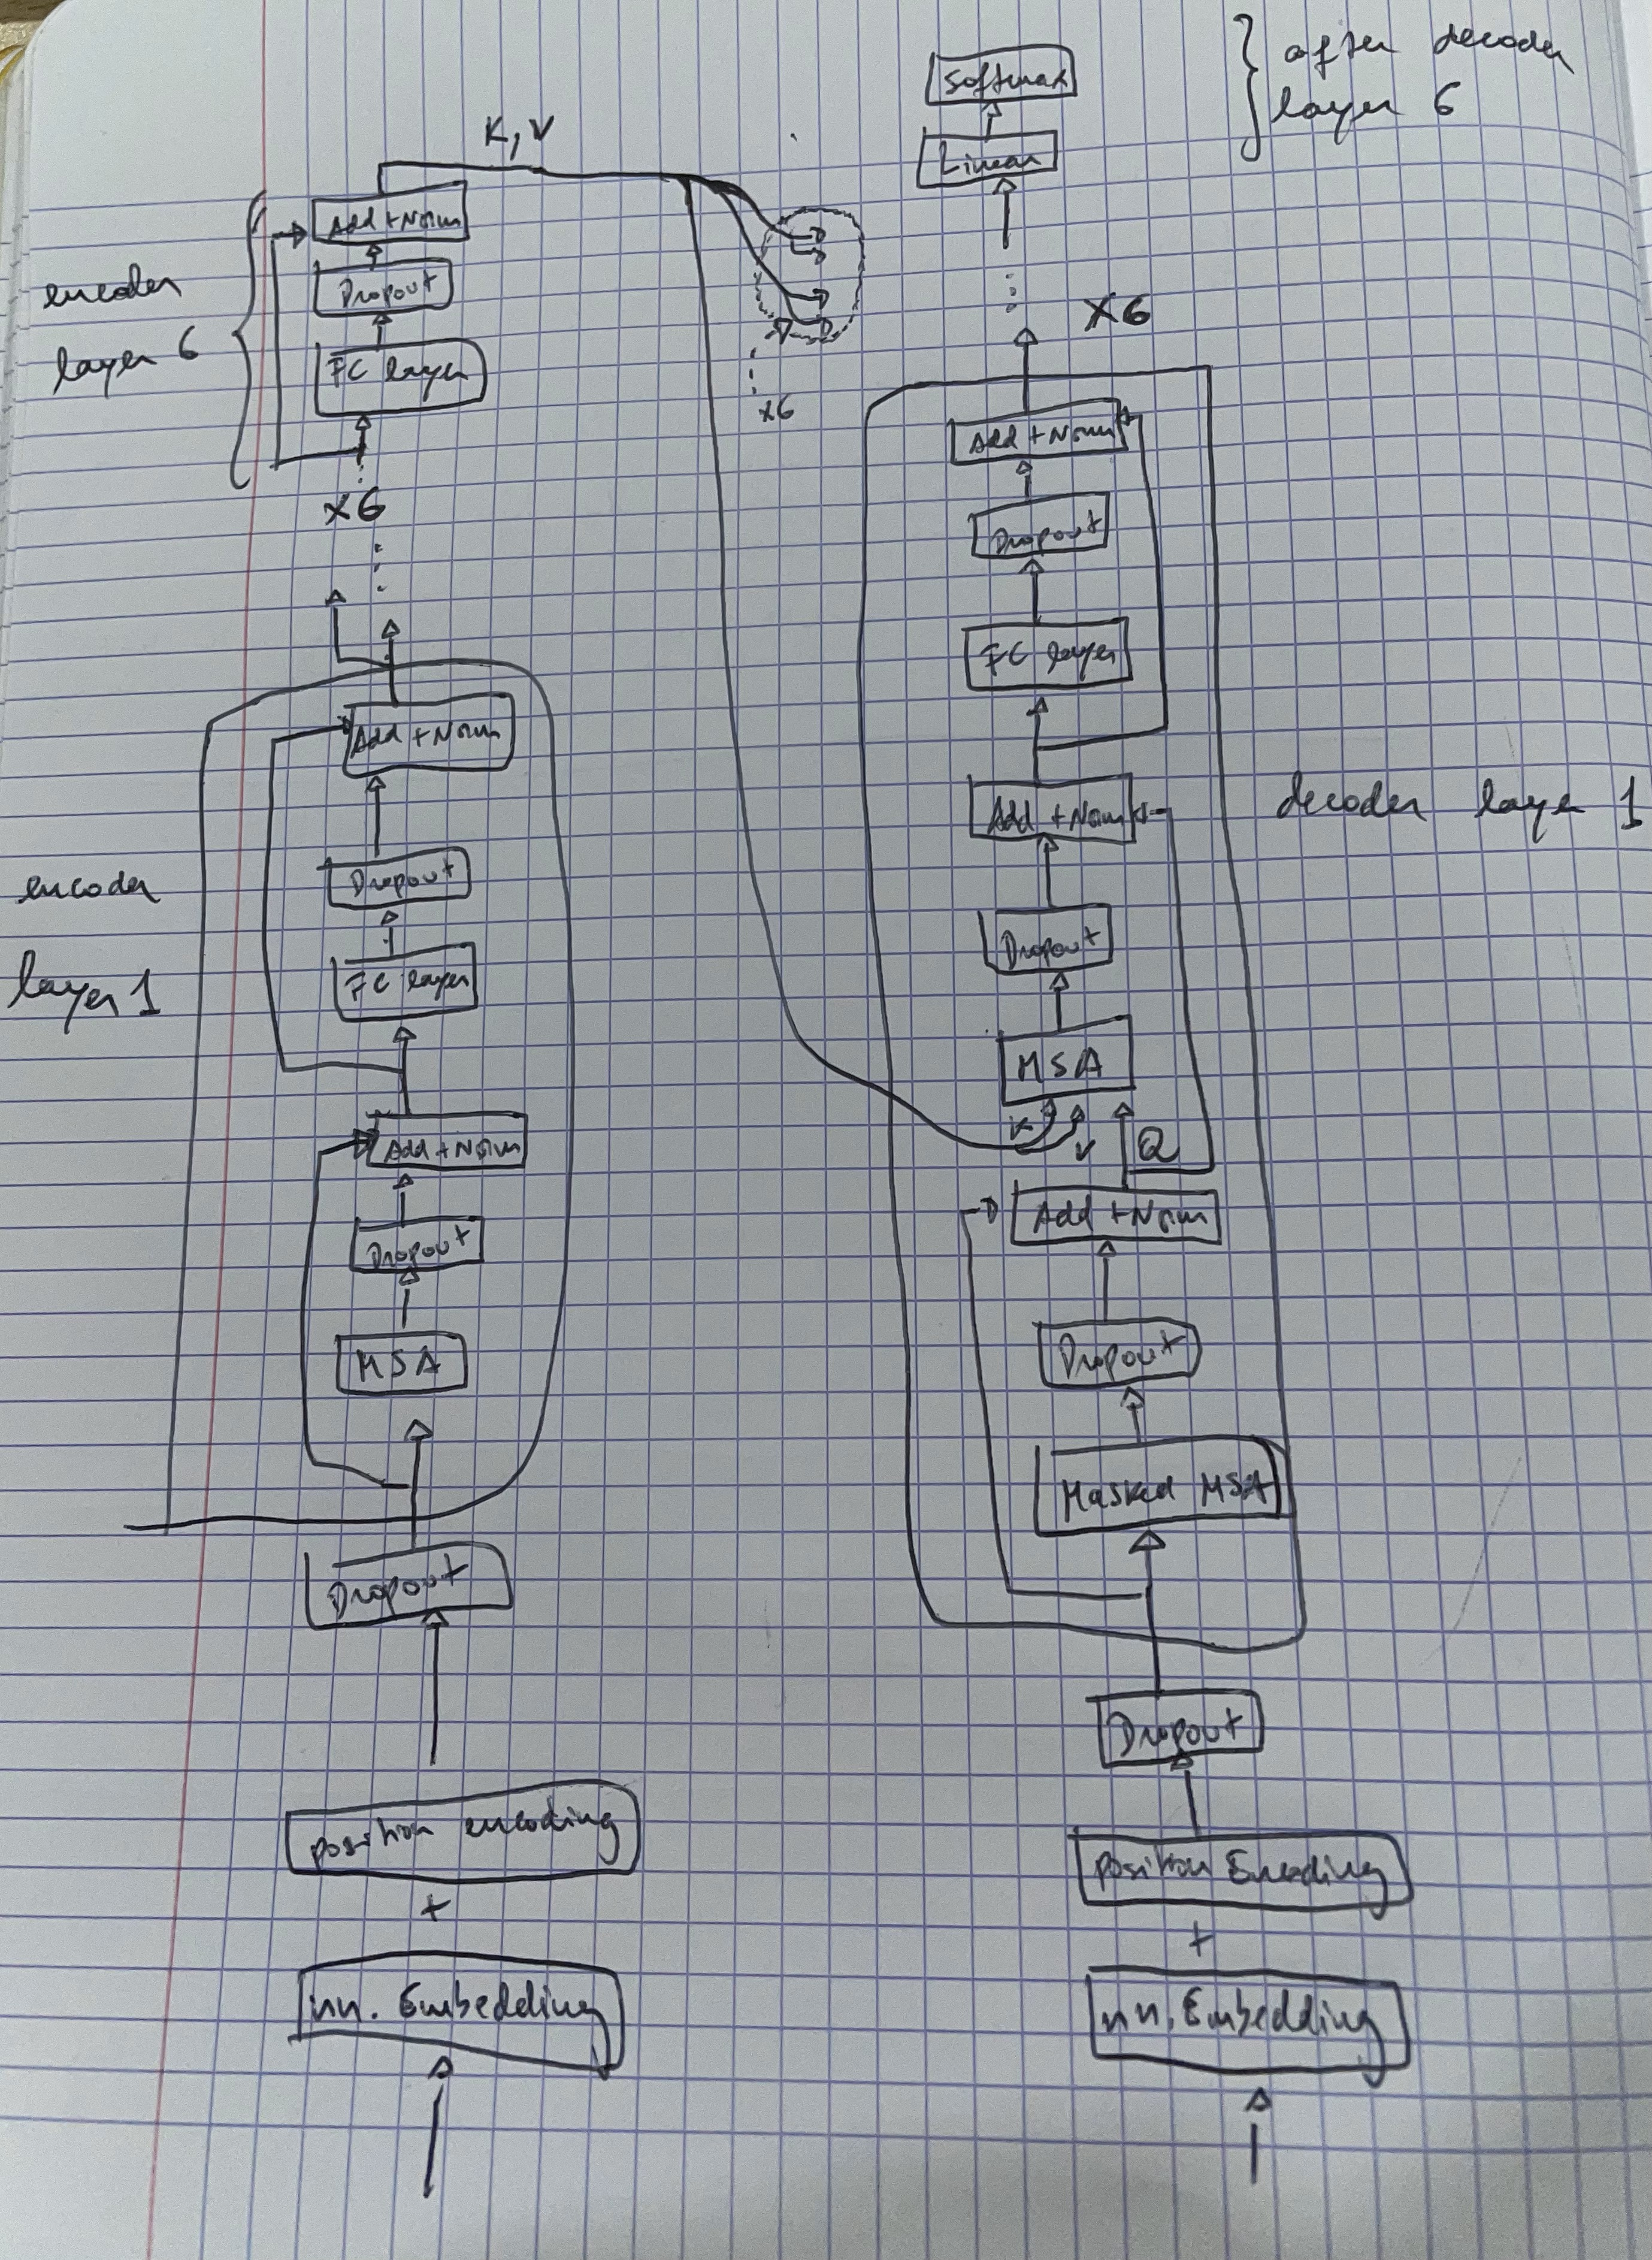

# Summary of the parameters
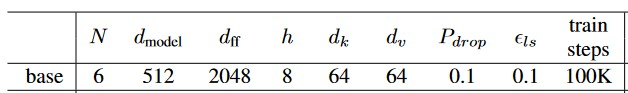
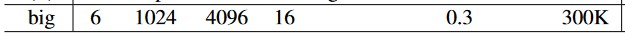

where:
- $N$: number of encoder and decoder layers;
- $d_{model}$: dimension of the model (dimension of each word in the vocabulary);
- $d_{ff}$: dimension of the inner linear layer in the FC layers;
- $h$: number of self-attention heads in each MSA layer;
- $d_{k}$: dimension of the keys for each projection;
- $d_{v}$: dimension of the values for each projection;
- $P_{drop}$: Dropout rate;
- $ϵ_{ls}$: label smoothing rate;
- $train steps$: number of epochs.

Additionally we have:
- target vocabulary size: 37000
- $batch\_size$: 25000
- $Adam(β_{1}=0.9, β_{2}=0.98, \epsilon=10^{-9}, learning\_rate=learning\_rate)$
  - $learning\_rate = d_{model}^{-0.5} . min(step\_num^{-0.5}, step\_num . warmup\_steps^{-1.5})$
  - $warmup\_steps = 4000$
- Beam search: $B = 4$, $α=0.6$

# Implementation

In [1]:
import os
from pathlib import Path
from typing import List, Dict, Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# huggingface transformers
try:
  from transformers import GPT2Tokenizer
except:
  print("Couldn't find transformers... installing.")
  !pip install -q transformers
  from transformers import GPT2Tokenizer

# huggingface datasets
try:
  from datasets import load_dataset
except:
  print("Couldn't find datasets... installing.")
  !pip install -q datasets
  from datasets import load_dataset

# torchinfo summary
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

Couldn't find datasets... installing.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
[INFO] Couldn't find torchinfo... installing it.


### For creating the full transformer model

In [2]:
# define learnable embedding module
class TransformerEmbedding(nn.Module):
  def __init__(self, vocab_size: int, d_model: int):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding_weights = nn.Parameter(torch.rand((self.vocab_size, self.d_model), dtype=torch.float),
                                  requires_grad=True)
    self.scale = torch.sqrt(torch.tensor(d_model, dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.embedding_weights[x] * self.scale, self.embedding_weights

class Attention(nn.Module):
  """Function to calculate Attention for a single example.
  Performs the matrix multiplication between the values matrix and the softmax
  of the scaled dot product between queries and keys.
  Expected shape for Attention: (batch, seq_len, d_k). d_k can be equal to d_model.

  Args:
    query (Tensor): the Queries matrix, or the Linear projection for the case of MSA.
    key (Tensor): the Keys matrix, or the Linear projection for the case of MSA.
    value (Tensor): the Values matrix, or the Linear projection for the case of MSA.
    d_k (int): the dimension of the keys to perform the scaling on the dot product.
    mask (Optional): the mask to apply masked Attention by setting values to -inf.

  Returns:
    the attention for the given Q, K, and V.
  """
  def __init__(self, d_k: int):
    super().__init__()
    self.d_k = d_k

  def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask=None):
    # shapes: (seq_len, d_k) x (d_k, seq_len) = (seq_len, seq_len)
    scaled_dot_product = torch.matmul(query, key.transpose(-2,-1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float))

    if mask is not None:
      scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, -float('inf'))

    # shapes: (seq_len, seq_len) x (seq_len, d_k) = (seq_len, dk)
    return torch.matmul(torch.softmax(scaled_dot_product, dim=-1), value)

# define multi head self attention module (allow mask to be applied)
class MultiHeadAttention(nn.Module):
  def __init__(self, h: int = 8, d_model: int = 512):
    super().__init__()
    self.h = h
    self.d_model = d_model
    self.d_k = self.d_model // self.h

    self.q_linear_proj = nn.Linear(self.d_model, self.d_model)
    self.k_linear_proj = nn.Linear(self.d_model, self.d_model)
    self.v_linear_proj = nn.Linear(self.d_model, self.d_model)

    self.attention = Attention(self.d_k)

    self.linear = nn.Linear(self.h * self.d_k, self.d_model)

  def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
    # Get batch from query shape
    batch_size = query.size()[0]

    q_proj = self.q_linear_proj(query).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
    k_proj = self.k_linear_proj(key).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
    v_proj = self.v_linear_proj(value).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

    attention_out = self.attention(q_proj, k_proj, v_proj, mask)

    return attention_out.transpose(1,2).contiguous().view(batch_size, -1, self.h * self.d_k)

# define fully connected feed forward module
class FFN(nn.Module):
  def __init__(self, d_model: int = 512, d_ff: int = 2048, p_dropout: float = 0.1):
    super().__init__()
    self.ffn = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model),
        nn.Dropout(p_dropout)
    )

  def forward(self, x: torch.Tensor):
    return self.ffn(x)

# define encoder block module
class EncoderLayer(nn.Module):
  def __init__(self, d_model: int = 512, d_ff: int = 2048, h: int = 8, p_dropout: float = 0.1):
    super().__init__()
    self.layer_norm_msa = nn.LayerNorm(normalized_shape=d_model)
    self.layer_norm_ffn = nn.LayerNorm(normalized_shape=d_model)
    self.msa = MultiHeadAttention(h=h, d_model=d_model)
    self.dropout = nn.Dropout(p_dropout)
    self.ffn = FFN(d_model=d_model, d_ff=d_ff, p_dropout=p_dropout)

  def forward(self, x: torch.Tensor, mask: torch.Tensor):
    x = self.layer_norm_msa(self.dropout(self.msa(x, x, x, mask)) + x)

    return self.layer_norm_ffn(self.ffn(x) + x)

# define decoder block module
class DecoderLayer(nn.Module):
  def __init__(self, d_model: int = 512, d_ff: int = 2048, h: int = 8, p_dropout: float = 0.1):
    super().__init__()
    self.layer_norm_msa_1 = nn.LayerNorm(normalized_shape=d_model)
    self.layer_norm_msa_2 = nn.LayerNorm(normalized_shape=d_model)
    self.layer_norm_ffn = nn.LayerNorm(normalized_shape=d_model)
    self.self_msa = MultiHeadAttention(h=h, d_model=d_model)
    self.dropout = nn.Dropout(p_dropout)
    self.encoder_decoder_msa = MultiHeadAttention(h=h, d_model=d_model)
    self.ffn = FFN(d_model=d_model, d_ff=d_ff, p_dropout=p_dropout)

  def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, mask: torch.Tensor):
    x = self.layer_norm_msa_1(self.dropout(self.self_msa(x, x, x, mask=mask)) + x)
    x = self.layer_norm_msa_2(self.dropout(self.encoder_decoder_msa(x, encoder_out, encoder_out)) + x)

    return self.layer_norm_ffn(self.ffn(x) + x)

# Define EncoderBlock
class EncoderBlock(nn.Module):
  def __init__(self, N: int, d_model: int = 512, d_ff: int = 2048, h: int = 8, p_dropout: float = 0.1):
    super().__init__()
    self.encoder_stack = nn.ModuleList([EncoderLayer(d_model, d_ff, h, p_dropout) for _ in range(N)])

  def forward(self, x: torch.Tensor, mask: torch.Tensor):
    for encoder_layer in self.encoder_stack:
      x = encoder_layer(x, mask)

    return x

# Define DecoderBlock
class DecoderBlock(nn.Module):
  def __init__(self, N: int, d_model: int = 512, d_ff: int = 2048, h: int = 8, p_dropout: float = 0.1):
    super().__init__()
    self.decoder_stack = nn.ModuleList([DecoderLayer(d_model, d_ff, h, p_dropout) for _ in range(N)])

  def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, mask: torch.Tensor):
    for decoder_layer in self.decoder_stack:
      x = decoder_layer(x, encoder_out, mask)

    return x

# define position encoding function
class PositionEncoding(nn.Module):
  def __init__(self, max_sequence_len: int, d_model: int, n: int = 10000):
    """Generates the positional encoding matrix to be added to the embeddings.
    The matrix will be of shape (max_sequence_len, d_model) allowing for direct addition to
    the token embedding.
    This will be initialized with the model, and added to the different embeddings in each batch.

    Args:
      max_sequence_len (int): The max length for any input sequence, the number of words (tokens) in the input.
      d_model (int): The dimension of the model. The base Transformer has dimension 512.
      n (Optional, int): A scalar to set the amplitude progression of the sinusoids. The default is 10000.

    Returns:
      A tensor of shape (max_sequence_len, d_model) containing the position encodings to be added to the embeddings.
    """
    super().__init__()
    self.max_sequence_len = max_sequence_len
    self.d_model = d_model
    self.n = n
    self.position_encoding = nn.Parameter(torch.zeros(self.max_sequence_len, self.d_model, dtype=torch.float), requires_grad=False)
    self.positions = torch.arange(self.max_sequence_len).unsqueeze(1)
    self.dimensions = torch.arange(self.d_model // 2)
    self.position_encoding[:,0::2] = torch.sin(self.positions / (n**( (2 * self.dimensions) / self.d_model )))
    self.position_encoding[:,1::2] = torch.cos(self.positions / (n**( (2 * self.dimensions) / self.d_model )))

  def forward(self):
    return self.position_encoding

# define head module
class DecoderHead(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, decoder_output: torch.Tensor, embedding_weights: nn.Parameter):
    return torch.matmul(decoder_output, embedding_weights.T)

# define Transformer module
class TransformerReplica(nn.Module):
  def __init__(self, vocab_size: int, max_sequence_len: int = 150, N: int = 6, d_model: int = 512, d_ff: int = 2048, h: int = 8, p_dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.max_sequence_len = max_sequence_len
    self.embedding = TransformerEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.position_encoding = PositionEncoding(self.max_sequence_len, self.d_model)
    self.dropout = nn.Dropout(p_dropout)
    self.encoder_block = EncoderBlock(N=N, d_model=d_model, d_ff=d_ff, h=h, p_dropout=p_dropout)
    self.decoder_block = DecoderBlock(N=N, d_model=d_model, d_ff=d_ff, h=h, p_dropout=p_dropout)
    self.decoder_head = DecoderHead()

  def forward(self, x: torch.Tensor, decoder_input: torch.Tensor, padding_mask: torch.Tensor, combined_mask: torch.Tensor):
    # Determine position encodings to use in the model
    position_encoding = self.position_encoding()

    # Apply embedding to the input
    x, embedding_weights = self.embedding(x)

    # Encode
    encoder_out = self.encoder_block(self.dropout(x  + position_encoding[:x.size()[1],:] ), padding_mask)

    # Decode
    # Pass y, x and mask through the decoder block
    # Last Linear layer is just a Matmul of the output with the embedding weights
    return self.decoder_head( self.decoder_block( self.dropout(self.embedding(decoder_input)[0] + position_encoding[:decoder_input.size()[1],:]), encoder_out, combined_mask ), embedding_weights )

In [3]:
# Define mask creation functions
def create_padding_mask(seq: torch.Tensor, pad_token: int) -> torch.Tensor:
    """Creates a padding mask for sequences.

    Args:
        seq (torch.Tensor): Input sequence of shape (batch_size, seq_len).
        pad_token (int): The token used for padding.

    Returns:
        torch.Tensor: Padding mask of shape (batch_size, 1, 1, seq_len).
    """
    mask = (seq != pad_token).unsqueeze(1).unsqueeze(2)  # Shape: (batch_size, 1, 1, seq_len)
    return mask

def create_look_ahead_mask(seq_len: int) -> torch.Tensor:
    """Creates a look-ahead mask for self-attention.

    Args:
        seq_len (int): The length of the input sequence.

    Returns:
        torch.Tensor: Look-ahead mask of shape (seq_len, seq_len).
    """
    mask = torch.tril(torch.ones((seq_len, seq_len))).unsqueeze(0)  # Shape: (1, seq_len, seq_len)
    return mask

def combine_masks(padding_mask, look_ahead_mask):
    if padding_mask is None:
        return look_ahead_mask

    return padding_mask * look_ahead_mask

In [4]:
# Create summary of the model (using batch size of 1 and setting sequence length of 15 in hopes of not blowing up the RAM)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create model using original target vocab_size found in paper.
model = TransformerReplica(vocab_size=50257).to(device) # keep the rest of parameters the default
summary(model=model,
        input_size=[(1, 25), (1, 25), (1, 1, 1, 25), (1, 25, 25)], # List of sizes for input [encoder_input, decoder_input, padding_mask, combined_mask]
        dtypes=[torch.int, torch.int, torch.bool, torch.bool],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TransformerReplica (TransformerReplica)                           [1, 25]              [1, 25, 50257]       --                   Partial
├─PositionEncoding (position_encoding)                            --                   [150, 512]           (76,800)             False
├─TransformerEmbedding (embedding)                                [1, 25]              [1, 25, 512]         25,731,584           True
├─Dropout (dropout)                                               [1, 25, 512]         [1, 25, 512]         --                   --
├─EncoderBlock (encoder_block)                                    [1, 25, 512]         [1, 25, 512]         --                   True
│    └─ModuleList (encoder_stack)                                 --                   --                   --                   True
│    │    └─EncoderLayer (0)                           

In [5]:
print(f"Trainable parameters excluding the Embedding: {63082496 - 18944000}.")
print(f"If we add the total of 2 extra LayerNorm layers: {(63082496 - 18944000) + 2048}")
print("This shows the exact same number in pytorch model below, which differs precisely on adding 1 LayerNorm after \
the Encoder stack and the Decoder stack.")

Trainable parameters excluding the Embedding: 44138496.
If we add the total of 2 extra LayerNorm layers: 44140544
This shows the exact same number in pytorch model below, which differs precisely on adding 1 LayerNorm after the Encoder stack and the Decoder stack.


**I need to revise the model as I appear to be generating a model with ~10M~ ~7M~ ~more~ 2M less parameters than what is described in the paper.**

*Note 1*: The **last Linear layer** was not supposed to exist, as in the paper they state **they use the same weights from the embedding**. Thus in the final step of the model, we do a matmul between the output and the weights matrix, transposed in order to get back the full vocab_size.

*Note 2*: There was a misinterpretation of mine regarding the linear projections on the q, k and v. Due to that misinterpretation, **I was putting one linear layer right after the other**, generating excess parameters, and as there is no non-linear activation between them this would still result in a linear combination of the type $xW+b$.

*Obs 1*: Since they mention vocabulary size **about** 37000, this could be what makes up for the difference between my model and theirs. Since a different vocabulary size leads to way more (or way less parameters) in the embedding.

---


#### Compare to Pytorch ```nn.Transformer```

In [6]:
torch_transformer = nn.Transformer().to(device)
summary(model=torch_transformer,
        input_size=[(1, 15, 512), (1, 15, 512)], # List of sizes for input [encoder_input, decoder_input, mask] -> [(batch_size, sequence_len, vocab_size), (batch_size, sequence_len, vocab_size), (sequence_len, sequence_len)]
        dtypes=[torch.float, torch.float],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Transformer (Transformer)                                    [1, 15, 512]         [1, 15, 512]         --                   True
├─TransformerEncoder (encoder)                               [1, 15, 512]         [1, 15, 512]         --                   True
│    └─ModuleList (layers)                                   --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)                      [1, 15, 512]         [1, 15, 512]         3,152,384            True
│    │    └─TransformerEncoderLayer (1)                      [1, 15, 512]         [1, 15, 512]         3,152,384            True
│    │    └─TransformerEncoderLayer (2)                      [1, 15, 512]         [1, 15, 512]         3,152,384            True
│    │    └─TransformerEncoderLayer (3)                      [1, 15, 512]         [1, 15, 51

This model has 21M less parameters than the reported in the paper. It seems to be missing a few layers which might need to be added by the user, namely the embedding. Assuming the same vocabulary size as above, the embedding layer produced in my model generates 18M parameters, so this would bring this architecture closer to the reported number of parameters.

# Training and testing

### Define train and test functions

In [7]:
# create train step
def train_step(model: nn.Module, dataloader: DataLoader, pad_token: int, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device = device) -> Tuple[float, float]:
  """Trains the Transformer model for 1 epoch.
  """
  model.train()

  train_loss = 0
  train_perplexity = 0

  for x, padding_mask_x, y, padding_mask_y in tqdm(dataloader, desc="training...", unit="batch"):
    # send input to device
    x, y = x.to(device), y.to(device)

    # setup padding and look-ahead masks
    # EDITING THIS FOR NOW FOR CURRENT USE CASE
    #padding_mask_x = create_padding_mask(x, pad_token).to(device)
    padding_mask_x = padding_mask_x.unsqueeze(1).unsqueeze(2).to(device)
    #padding_mask_y = create_padding_mask(y, pad_token).to(device)
    padding_mask_y = padding_mask_y.unsqueeze(1).unsqueeze(2).to(device)

    look_ahead_mask = create_look_ahead_mask(y.size(1)).to(device)
    combined_mask = combine_masks(padding_mask_y, look_ahead_mask).to(device)

    # pass through the model
    logits = model(x, y, padding_mask_x, combined_mask)

    # compute loss and perplexity
    flat_logits = logits.view(-1, logits.size(2))
    flat_target = y.view(-1)
    loss = loss_fn(flat_logits, flat_target)
    train_perplexity += torch.exp(loss).item()

    train_loss += loss.item()

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # optimizer step
    optimizer.step()

  # Get the averages per batch
  train_loss = train_loss / len(dataloader)
  train_perplexity = train_perplexity / len(dataloader)

  return train_loss, train_perplexity

# create test step
def test_step(model: nn.Module, dataloader: DataLoader, pad_token: int, loss_fn: nn.Module, device: torch.device = device) -> Tuple[float, float]:
  """ Performs inference on the Transformers model for 1 epoch.
  """
  test_loss, test_perplexity = 0, 0

  model.eval()
  with torch.inference_mode():
    for x, y in tqdm(dataloader, desc="testing...", unit="batch"):
      # Send data to device
      x, y = x.to(device), y.to(device)

      # setup masks
      padding_mask_x = create_padding_mask(x, pad_token).to(device)
      padding_mask_y = create_padding_mask(y, pad_token).to(device)
      look_ahead_mask = create_look_ahead_mask(y.size(1)).to(device)
      combined_mask = combine_masks(padding_mask_y, look_ahead_mask).to(device)

      # pass through the model
      logits = model(x, y, padding_mask_x, combined_mask)

      # compute loss and perplexity
      flat_logits = logits.view(-1, logits.size(2))
      flat_target = y.view(-1)
      loss = loss_fn(flat_logits, flat_target).item()
      test_loss += loss
      test_perplexity += torch.exp(loss)

      # TODO: implement bleu score (torchtext.data.metrics.bleu_score)

    test_loss = test_loss / len(dataloader)
    test_perplexity = test_perplexity / len(dataloader)

  return test_loss, test_perplexity

# create training loop
def train_model(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, pad_token: int, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, epochs: int, device: torch.device = device):
  """Trains the given model for the given number of epochs.
  """
  results = {
      "train_loss": [],
      "train_perplexity": [],
      "test_loss": [],
      "test_perplexity": []
  }
  # TODO: implement bleu score

  for epoch in tqdm(range(epochs), desc="Training model...", unit="epoch"):
    train_loss, train_perplexity = train_step(model=model, dataloader=train_dataloader, pad_token=pad_token, loss_fn=loss_fn, optimizer=optimizer, device=device)
    test_loss, test_perplexity = test_step(model=model, dataloader=test_dataloader, pad_token=pad_token, loss_fn=loss_fn, device=device)

    results['train_loss'].append(train_loss)
    results['train_perplexity'].append(train_perplexity)
    results['test_loss'].append(test_loss)
    results['test_perplexity'].append(test_perplexity)

    if epoch % 2 == 0:
      print(f"Epoch: {epoch}\n \
      train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}\n \
      train_perp: {train_perplexity:.2f}, test_perp: {test_perplexity:.2f}")

  return results

# create function to visualize learning curves
def plot_learning_curves(results: Dict[str, List[float]]):
  """Plots the learning curves for the given results dictionary.

  Args:
    results (dict): A dictionary containing the train and test loss and perplexity lists of values for each epoch the model trained.
  """
  epochs = len(results["train_loss"])

  fig, ax = plt.subplots(1, 2, figsize=(10, 10))

  # Plot loss
  ax[0].plot(epochs, results["train_loss"], label='train_loss')
  ax[0].plot(epochs, results["test_loss"], label='test_loss')
  ax[0].set_title("loss curves")
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")
  plt.legend()

  # Plot perplexity
  ax[1].plot(epochs, results["train_perplexity"], label='train_perplexity')
  ax[1].plot(epochs, results["test_perplexity"], label='test_perplexity')
  ax[1].set_title("perplexity curves")
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("perplexity")
  plt.legend();

### Get data and configure parameters for training the model

In [8]:
# define seed
SEED = 14

# setup  device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# setup parameters
BATCH = 12
NUM_WORKERS = os.cpu_count()
MAX_SEQ_LEN = 128

# setup hyperparameters
ADAM_LR = 0.01 # will not use rate schedule right away
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.98
ADAM_EPSILON = 10**(-9)
LABEL_SMOOTHING = 0.1
BEAM_B = 4
BEAM_ALPHA = 0.6

In [ ]:
# Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# setup tokenizer to pass to dataloader/dataset transforms: get tokenizer from huggingface transformers (requires installing transformers module with pip)
print("Retrieving gpt2 tokenizer from Hugginface...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', clean_up_tokenization_spaces=True)
special_tokens_dict = {'bos_token': '<sos>', 'eos_token': '<eos>', 'pad_token': '<pad>'}
tokenizer.add_special_tokens(special_tokens_dict)
vocab_size = tokenizer.vocab_size
print(f"Tokenizer setup successfully. Vocab size: {vocab_size}")

# Get the data
# Load the dataset (English-German pair)
# dataset = load_dataset('wmt14', 'de-en')
# Start by creating a small subset of the 4M examples.
# Navigate folder system
print("Configuring dataset. Using wmt14 dataset from Huggingface.")
print("Only utilizing part 1 of 3 for the training data, corresponding to 1.5M examples.")
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/data/transformers_data")
train_data = data_dir / 'train-00000-of-00003.parquet'
val_data = data_dir / 'validation-00000-of-00001.parquet'
test_data = data_dir / 'test-00000-of-00001.parquet'
dataset = load_dataset("parquet", data_files={'train': str(train_data), 'test': str(test_data), 'validation': str(val_data)})
print("Huggingface dataset created!")

# transform data
def tokenize_function(examples):
  source = [example['en'] for example in examples['translation']]
  target = ["<sos>" + example['de'] + "<eos>" for example in examples['translation']]
  source = tokenizer(source, padding='max_length', truncation=True, return_tensors='pt', max_length=MAX_SEQ_LEN)
  target = tokenizer(target, padding='max_length', truncation=True, return_tensors='pt', max_length=MAX_SEQ_LEN)

  return {'input_ids': source['input_ids'],
          'padding_mask': source['attention_mask'],
          'labels': target['input_ids'],
          'decoder_attention_mask': target['attention_mask']}

print("Applying tokenizer to dataset...")
# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Format for PyTorch
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'padding_mask', 'labels', 'decoder_attention_mask'])
# TODO: the masks will not have the correct shape, need to maken sure they do.
print("Tokenizer applied!")

# Create DataLoaders
print("Creating DataLoaders")
train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=BATCH, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=BATCH, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
print("DataLoaders created!")

# Create model instance
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

transformer_model = TransformerReplica(vocab_size=vocab_size).to(device)

# Create learning rate scheduler, optimizer and loss function
loss_function = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = torch.optim.Adam(params=transformer_model.parameters(), lr=ADAM_LR, betas=(ADAM_BETA_1, ADAM_BETA_2), eps=ADAM_EPSILON)

### Train model

In [ ]:
# train code with configuration above for 1 epoch
results = train_model(model=transformer_model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      pad_token='<pad>',
                      loss_fn=loss_function,
                      optimizer=optimizer,
                      epochs=1,
                      device=device)

results
# train code with configuration above for some more epochs

### Visualization

In [ ]:
# plot learning curves
# print a few examples
# compare original results with the ones obtained from adapting to current resources

# Testing / Visualizing some of the functions

In [ ]:
# Test encoding function.
##########################
# Since we need to be aware of batches, and we need to figure automatically the sizes,
# it might be best to turn it into a subclass of nn.Module with no learnable parameters.
# Alternatively we can define (guesstimate) a max size for the number of words/tokens, determine the position encoding once and
# apply according to the different sizes inside the model. This might be the best alternative as we only calculate the encodings once, the rest is just simple slicing and addition.

def position_encoding(max_sequence_len: int, d_model: int, n: int = 10000):
    """Generates the positional encoding matrix to be added to the embeddings.
    The matrix will be of shape (max_sequence_len, d_model) allowing for direct addition to
    the token embedding.
    This will be initialized with the model, and added to the different embeddings in each batch.

    Args:
      max_sequence_len (int): The max length for any input sequence, the number of words (tokens) in the input.
      d_model (int): The dimension of the model. The base Transformer has dimension 512.
      n (Optional, int): A scalar to set the amplitude progression of the sinusoids. The default is 10000.

    Returns:
      A tensor of shape (max_sequence_len, d_model) containing the position encodings to be added to the embeddings.
    """
    position_encoding = torch.zeros(max_sequence_len, d_model, dtype=torch.float)
    positions = torch.arange(max_sequence_len).unsqueeze(1)
    dimensions = torch.arange(d_model/2)
    position_encoding[:,0::2] = torch.sin(positions / (n**( (2 * dimensions) / d_model )))
    position_encoding[:,1::2] = torch.cos(positions / (n**( (2 * dimensions) / d_model )))

    return position_encoding

test_encoding = position_encoding(100, 512)

plt.matshow(test_encoding)
plt.title('Encoding for 100 tokens sequence with dmodel = 512')
plt.xlabel('dimension i')
plt.ylabel('position')
plt.colorbar()
plt.show()

In [ ]:
# Get first 4 dimensions, transposing for being able to plot across the first 30 positions
first_four_dims = test_encoding[:30,:4].T

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, dim in enumerate(first_four_dims):
  axs[i].plot(dim)
  axs[i].set_title(f'wave for dimension: {i}')

plt.show()